The directory data/bacteria/ contains "microscope images" from experiments done with three different bacteria, b1, b2 and b3, each treated with three different drugs, d1, d2 and d3.
The image are named according to bacteria and drug.
We will process and analyse the images to see how the drugs have affected the sizes of the colonies the bacterias create. We will look at the area of the colonies.

Then we will create a data table with all the collected data.

Look at the images and see if you can figure out what preprocessing need to be done before labeling the colonies.

Basic algorithmic layout:

use a for loop to loop over the needed files in the directory and to the following for each file:
    you probably need the index as well

open the tiff image and fetch the user defined metadata and read the image data.

preprocess
apply filters

remove items touching border

connected component analysis
labeling

print how many colonies are found
plot the image

Store the loaded images,the labeld images and the metadata in arrays for later use!

{"bacteria":"b1","drug":"control"}
Number of colonies detected: 26


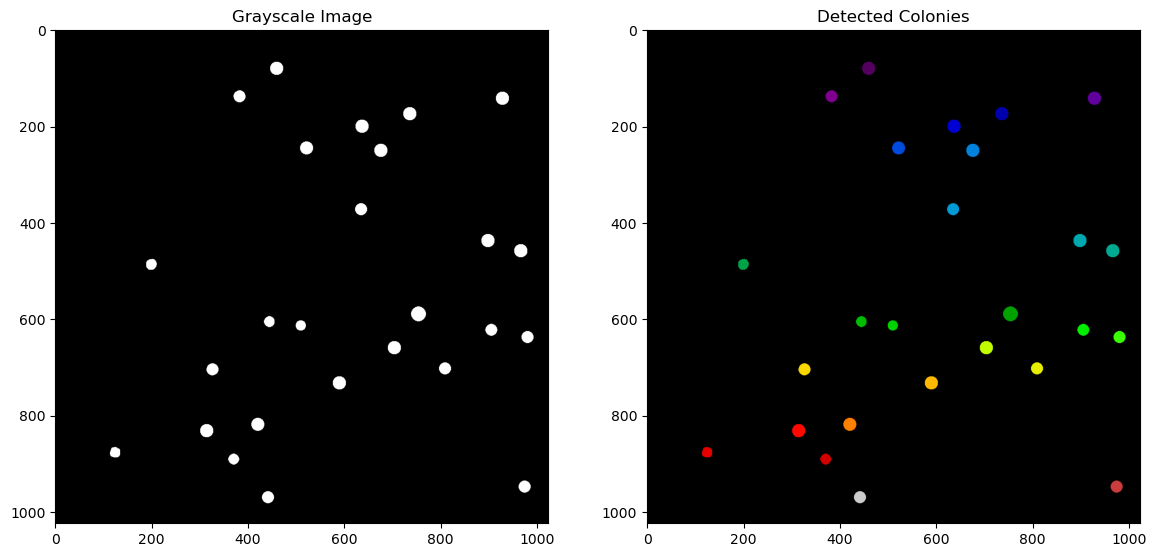

{"bacteria":"b1","drug":"d1"}
Number of colonies detected: 29


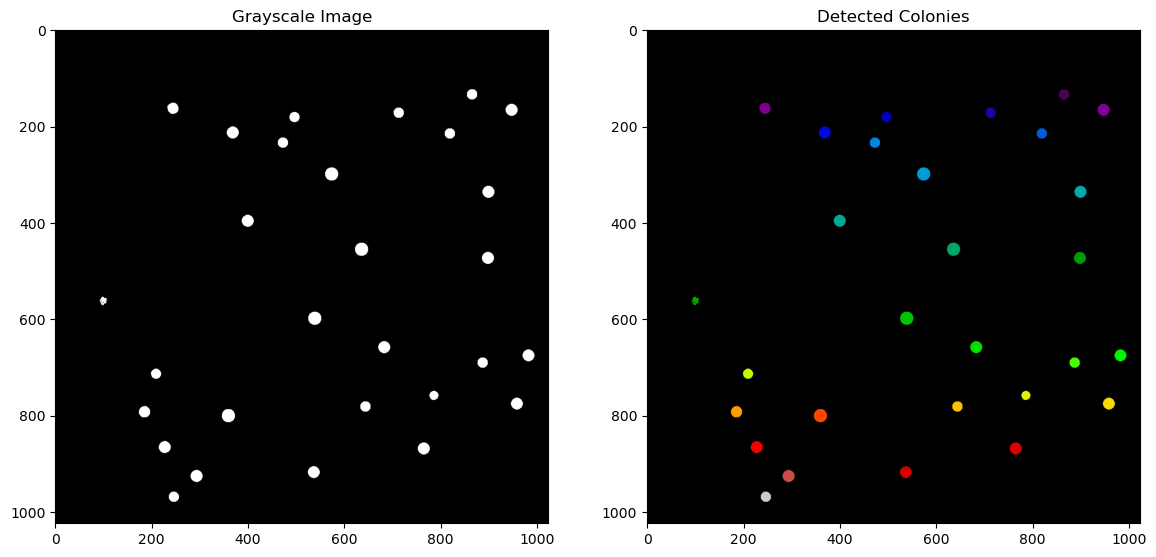

{"bacteria":"b1","drug":"d2"}
Number of colonies detected: 30


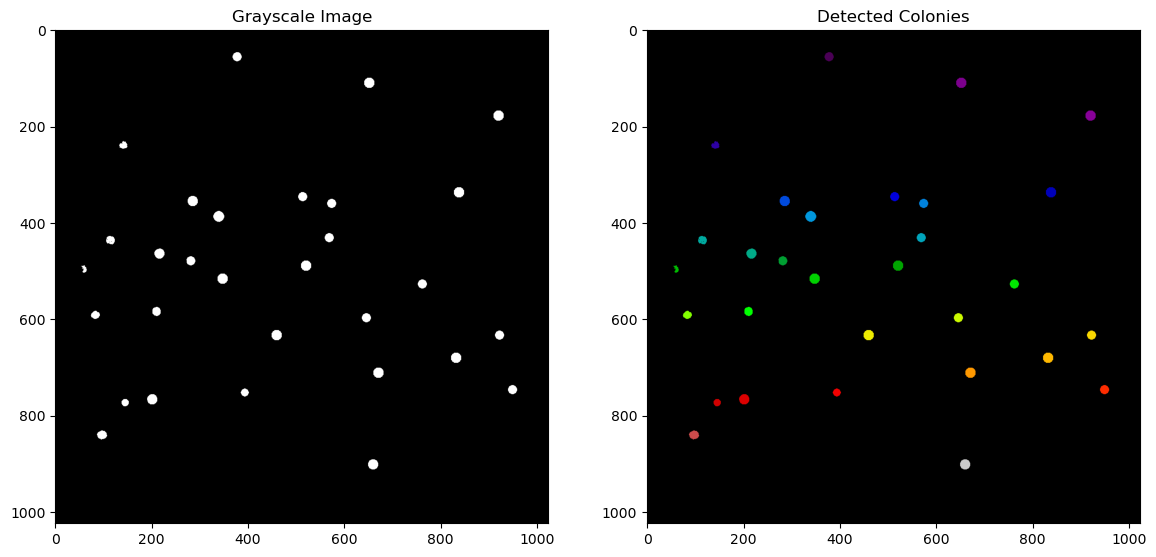

{"bacteria":"b1","drug":"d3"}
Number of colonies detected: 28


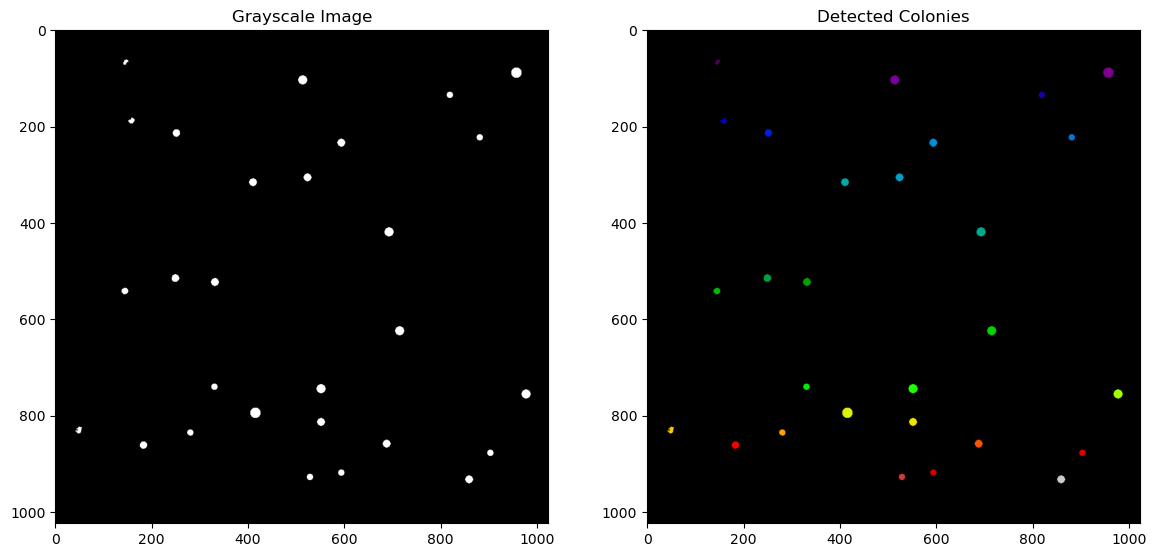

{"bacteria":"b2","drug":"control"}
Number of colonies detected: 30


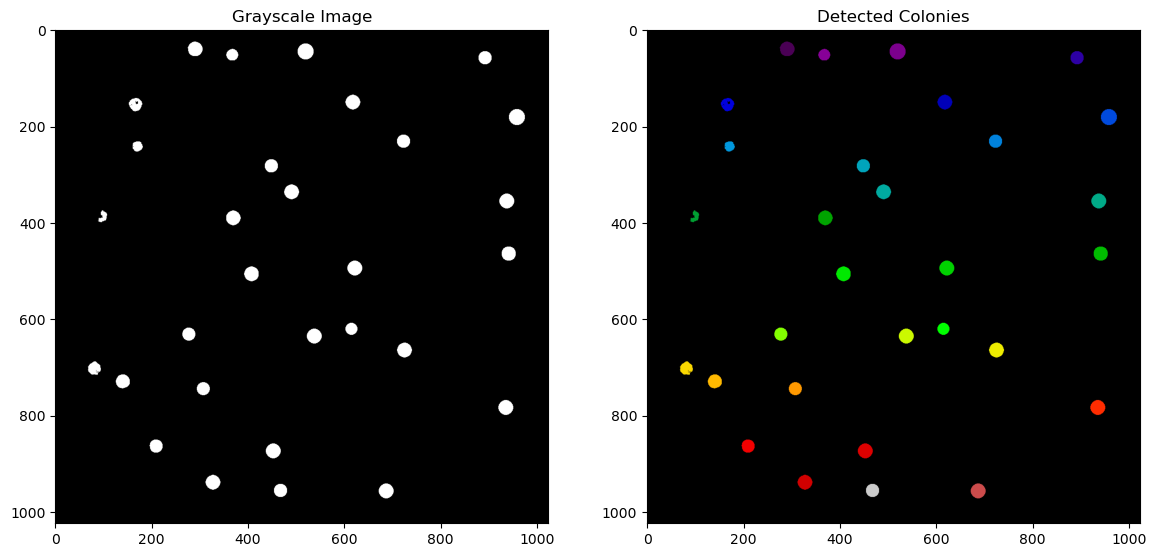

{"bacteria":"b2","drug":"d1"}
Number of colonies detected: 29


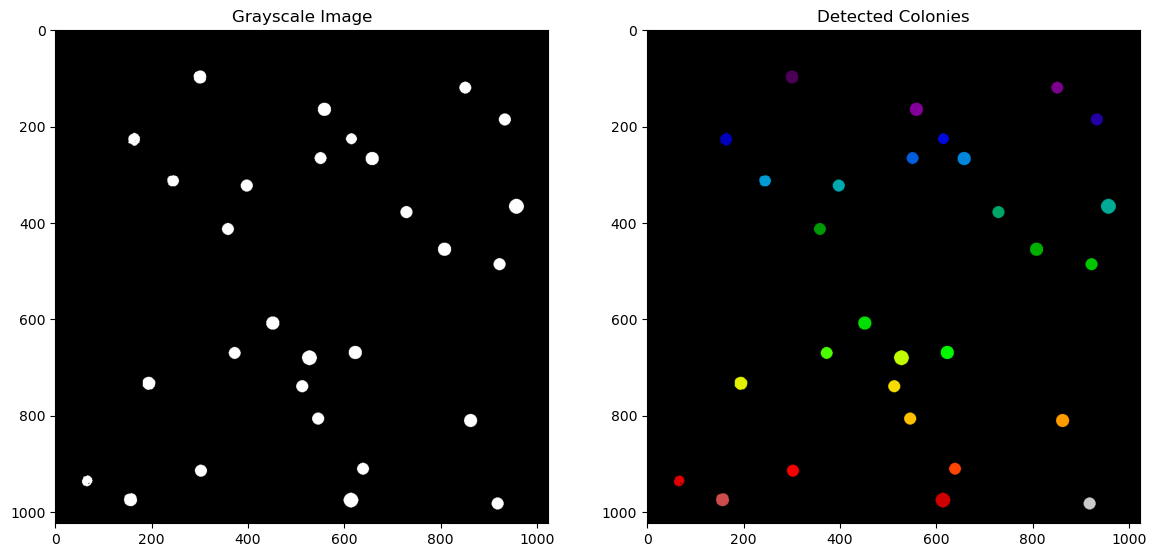

{"bacteria":"b2","drug":"d2"}
Number of colonies detected: 30


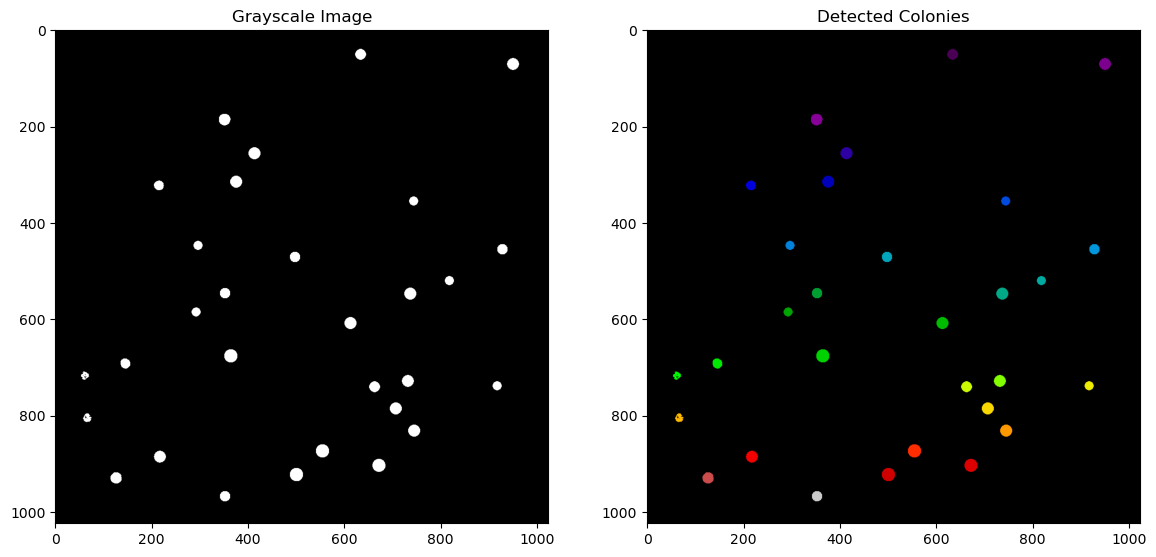

{"bacteria":"b2","drug":"d3"}
Number of colonies detected: 26


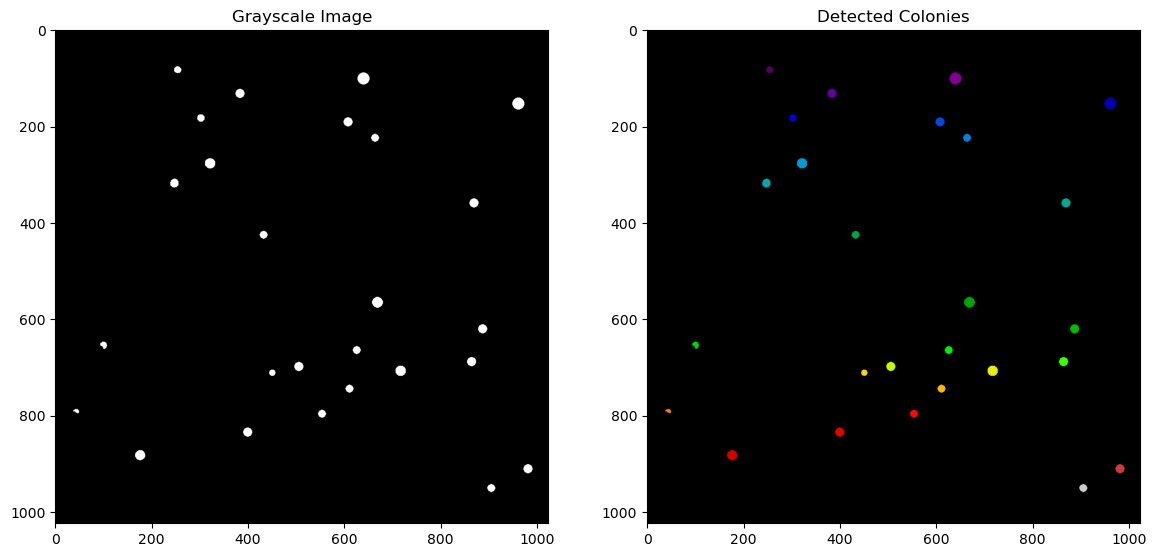

{"bacteria":"b3","drug":"control"}
Number of colonies detected: 29


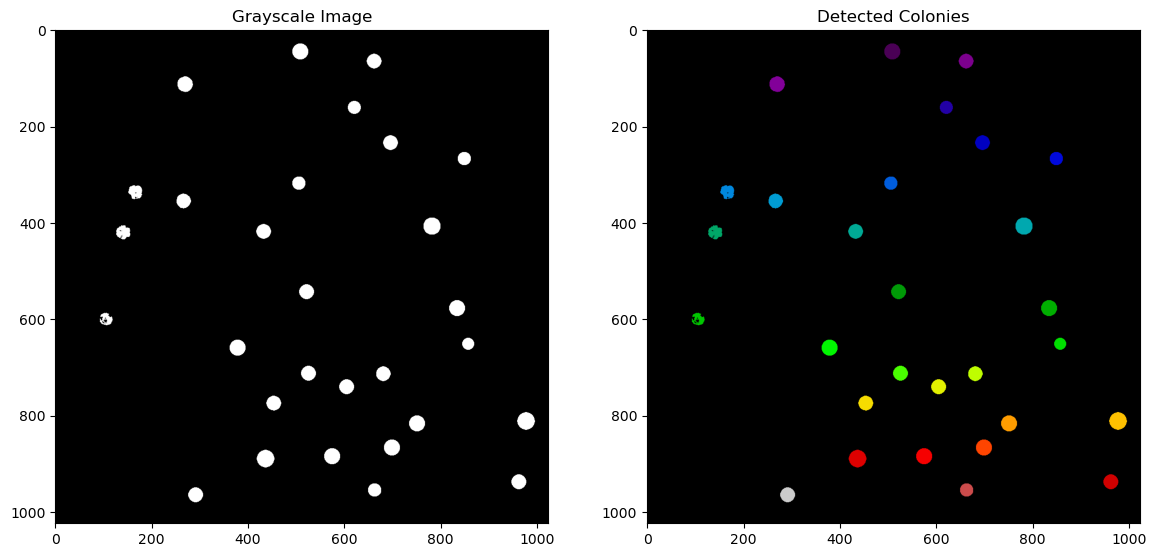

{"bacteria":"b3","drug":"d1"}
Number of colonies detected: 29


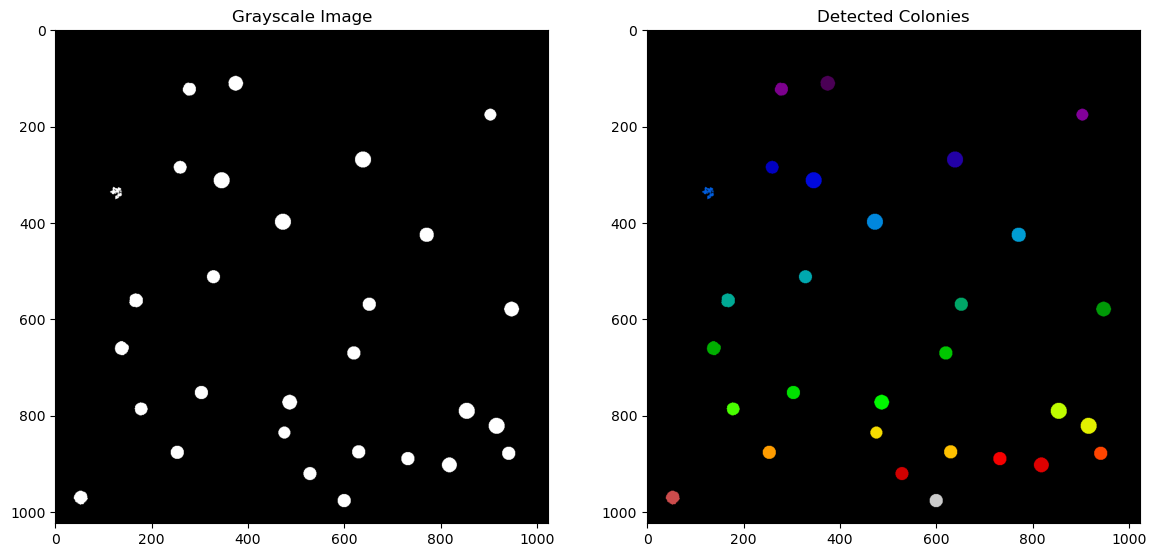

{"bacteria":"b3","drug":"d2"}
Number of colonies detected: 30


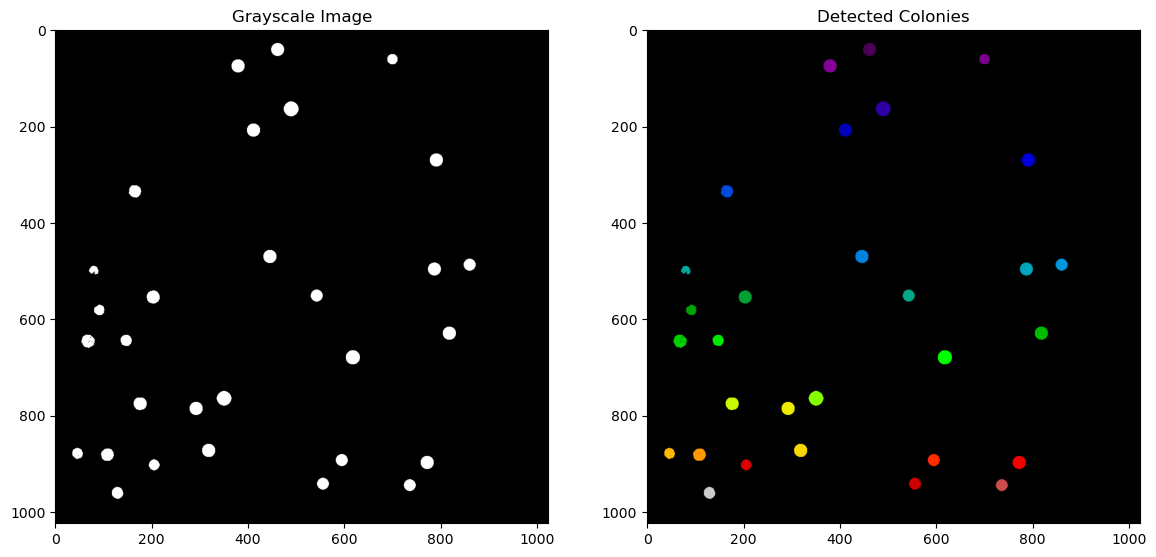

{"bacteria":"b3","drug":"d3"}
Number of colonies detected: 25


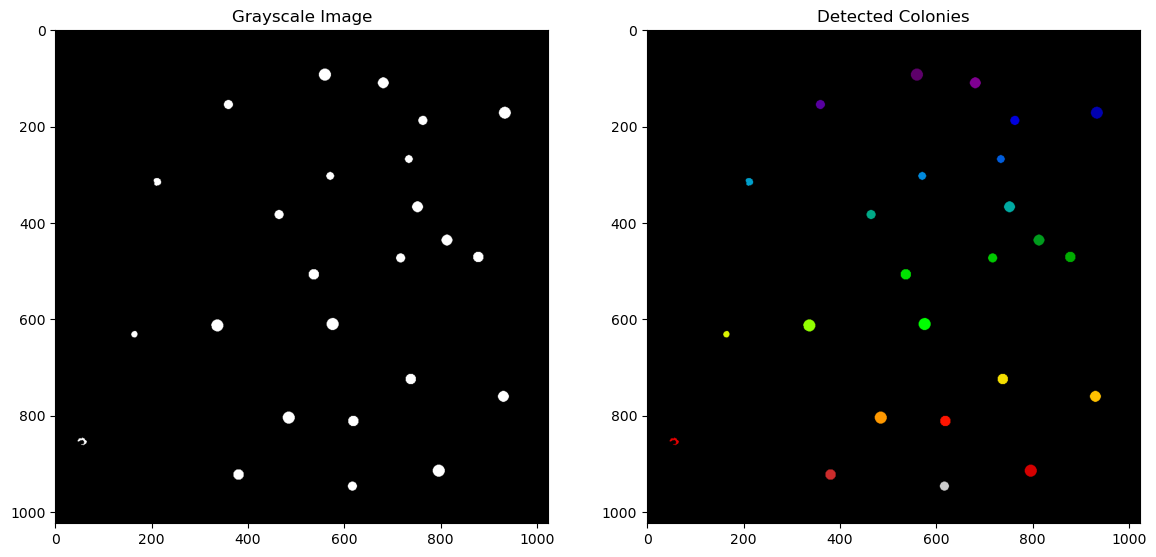

In [9]:

import matplotlib.pyplot as plt
from skimage import io, color,measure
from skimage.filters import gaussian, median, threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import area_opening, disk
import glob
import tifffile

#image directory
img_dir = "../data/bacteria/"  
labeled = []
images = []
metadata = []

for i, img_name in enumerate(glob.glob(img_dir + "*.tiff")):
    
    # 1. Load the image
    
    with tifffile.TiffFile(img_name) as tif:
        page = tif.pages[0]
        desc = page.tags["ImageDescription"].value
        img = tif.asarray()
    
    metadata.append(desc)
    images.append(img)   # replace with your image
    image = images[i]
    gray = color.rgb2gray(image)

    #use median filter to remove salt & pepper noise
    median_bg = median(gray, disk(4))

    print(metadata[i])

    # use gaussian filter to estimate uneven background illumination
    gaussian_bg = gaussian(gray,sigma=200,preserve_range=True)

    # subtract background fr
    gray = median_bg - gaussian_bg
    
    # 2. Threshold the image to separate colonies from background
    thresh = threshold_otsu(gray)
    binary = gray < thresh   # invert if colonies appear dark

    # remove segmentations that touch the border of the iamge
    binary = clear_border(binary)

    # remove small objects
    cleaned = area_opening(binary, area_threshold=70)

    # 4. Label connected regions (colonies). You might want to set the background parameter. Look at the documentation.
    labeled.append(measure.label(cleaned, background=0))
    labeled_img = labeled[i]
    regions = measure.regionprops(labeled_img)

    # 5. Print colony sizes.
    print("Number of colonies detected:", len(regions))

    # 6. Visualize results
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].imshow(cleaned, cmap="gray")
    ax[0].set_title("Grayscale Image")
    ax[1].imshow(labeled_img, cmap="nipy_spectral")
    ax[1].set_title("Detected Colonies")
    plt.show()


Now, lets collect the data and store it in a data fram for statistical analysis later

Create tables of regions of all the loaded images and labled images by using '''skimage.measure.regionprops_table(...)'''

Create panda frames from each table by adding the bacteria, the drug and the area for each colony.
Bacteria and Drug are stored int he metadata.

Use json package to read out bacteria and drug for each image/metadata

Concatenate all frames to a single frame and save it as csv


In [10]:

import pandas as pd
import json

frame_total = pd.DataFrame()
for i in range(len(labeled)):
    
    
    props = measure.regionprops_table(labeled[i], images[i],
                           properties=['area','feret_diameter_max'])

    frame = pd.DataFrame(props)
    
    info = json.loads(metadata[i])
    bacteria = info["bacteria"]
    drug = info["drug"]
    
    frame["bacteria"] = bacteria
    frame["drug"] = drug
    
    frame_total = pd.concat([frame_total, frame]) 

frame_total.to_csv('../data/bacteria_results_total.csv')
frame_total.describe()
#frame_total.head(40)


,area,feret_diameter_max
count,341.000000,341.000000
mean,467.296188,25.269522
std,194.394649,5.217867
min,72.000000,13.000000
25%,321.000000,22.472205
50%,486.000000,26.248809
75%,593.000000,28.792360
max,1025.000000,37.656341
